In [1]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [2]:
import joblib
from skimage.io import imread
from skimage.transform import resize

data = 'archive/Garbage classification/Garbage classification'

def resize_all(src, pklname, include, width=150, height=None):
    
    data = dict()
    data['description'] = f'resized ({width}x{height})garbage images in rgb'
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
    
    pklname = f"{pklname}_{width}x{height}px.pkl"
    
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) 
                    data['label'].append(subdir)
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)


data_path = 'archive/Garbage classification/Garbage classification'
os.listdir(data_path)

['paper', '.DS_Store', 'metal', 'cardboard', 'trash', 'glass', 'plastic']

In [3]:
base_name = 'garbage_classes'
width = 96
height = 128

# Found that no resizing improved accuracy 
include = {'glass', 'paper', 'cardboard', 
           'metal', 'plastic', 'trash'}

resize_all(src=data_path, pklname=base_name, width=width, height=height, include=include)

paper
metal
cardboard
trash
glass
plastic


In [4]:
from collections import Counter
 
data = joblib.load(f'{base_name}_{width}x{height}px.pkl')

Counter(data['label'])

Counter({'paper': 594,
         'metal': 410,
         'cardboard': 403,
         'trash': 137,
         'glass': 501,
         'plastic': 482})

In [5]:
X = np.array(data['data'])
y = np.array(data['label'])

In [6]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
import skimage
from skimage.feature import hog
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: 
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [8]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer

grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(2021, 1440)


In [9]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

SGDClassifier(random_state=42)

In [10]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

In [11]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

[False False  True False False  True False False  True  True  True False
  True False False False  True False False  True  True  True  True  True
  True]

Percentage correct:  50.98814229249012


### Optimization

In [13]:
from sklearn.pipeline import Pipeline
from sklearn import svm
 
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

Percentage correct:  50.98814229249012


In [14]:
from sklearn.model_selection import GridSearchCV
 
param_grid = [
    {
        'hogify__orientations': [8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3)],
        'hogify__pixels_per_cell': [(8, 8), (10, 10), (12, 12)]
    },
    {
         'classify': [
             SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
             svm.SVC(kernel='linear')
         ]
    }
]

In [15]:
grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           cv=3,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


In [16]:
# save the model to disk
joblib.dump(grid_res, 'hog_sgd_model.pkl');

In [17]:
# description of the best performing object, a pipeline in our case.
grid_res.best_estimator_

Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer(cells_per_block=(2, 2))),
                ('scalify', StandardScaler()),
                ('classify', SGDClassifier(random_state=42))])

In [18]:
# the highscore during the search
grid_res.best_score_

0.5408155166864343

In [19]:
pp.pprint(grid_res.best_params_)

{   'hogify__cells_per_block': (2, 2),
    'hogify__orientations': 9,
    'hogify__pixels_per_cell': (8, 8)}


In [20]:
best_pred = grid_res.predict(X_test)
print('Percentage correct: ', 100*np.sum(best_pred == y_test)/len(y_test))

Percentage correct:  52.96442687747036


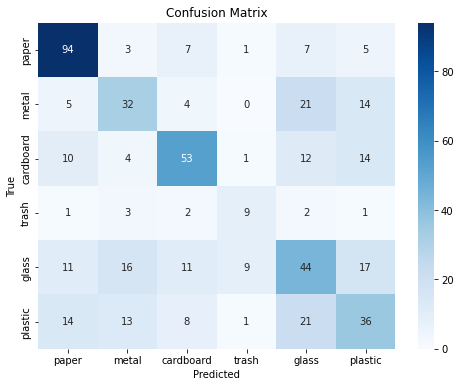

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

label_names = ['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic'] 
cmx = confusion_matrix(y_test, best_pred, labels=label_names)

df_cmx = pd.DataFrame(cmx, columns=label_names, index=label_names)

plt.figure(figsize=(8, 6))
sns.heatmap(df_cmx, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# Get classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, best_pred, target_names=label_names))

              precision    recall  f1-score   support

       paper       0.62      0.56      0.59        94
       metal       0.41      0.41      0.41       108
   cardboard       0.45      0.42      0.44        76
       trash       0.70      0.80      0.75       117
       glass       0.41      0.39      0.40        93
     plastic       0.43      0.50      0.46        18

    accuracy                           0.53       506
   macro avg       0.50      0.51      0.51       506
weighted avg       0.52      0.53      0.53       506

